# Basic occupancy analysis

COMING SOON

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import hillmaker as hm

## A prototypical example - occupancy analysis of a hospital Short Stay Unit

Patients flow through a short stay unit (SSU) for a variety of procedures, tests or therapies. Let's assume patients can be classified into one of five categories of patient types: ART (arterialgram), CAT (post cardiac-cath), MYE (myelogram), IVT (IV therapy), and OTH (other). We are interested in occupancy statistics by time of day and day of week to support things like staff scheduling and capacity planning.

From one of our hospital information systems we were able to get raw data about the entry and exit times of each patient and exported the data to a csv file. We call each row of such data a *stop* (as in, the patient stopped here for a while). Let's take a peek at the data by first reading the csv file into a pandas `DataFrame`.

In [3]:
ssu_stopdata = './data/ssu_2024.csv'
stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
stops_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [4]:
ssu_all = hm.Scenario(scenario_name='ssu_all',
                      data=stops_df,
                      in_field='InRoomTS',
                      out_field='OutRoomTS',
                      start_analysis_dt='2024-01-02',
                      end_analysis_dt='2024-09-30',
                      cat_field='PatType',
                      bin_size_minutes=60,
                      cap=100,
                      verbosity=1,
                     )

In [5]:
print(ssu_all)

Required inputs
-------------------------
scenario_name = ssu_all
data =
       PatID            InRoomTS           OutRoomTS PatType  LOS_hours
0          1 2024-01-01 07:44:00 2024-01-01 09:20:00     IVT   1.600000
1          2 2024-01-01 08:28:00 2024-01-01 11:13:00     IVT   2.750000
2          3 2024-01-01 11:44:00 2024-01-01 12:48:00     MYE   1.066667
3          4 2024-01-01 11:51:00 2024-01-01 21:10:00     CAT   9.316667
4          5 2024-01-01 12:10:00 2024-01-01 12:57:00     IVT   0.783333
...      ...                 ...                 ...     ...        ...
59872  59873 2024-09-30 19:31:00 2024-09-30 20:34:00     IVT   1.050000
59873  59874 2024-09-30 20:23:00 2024-09-30 22:22:00     IVT   1.983333
59874  59875 2024-09-30 21:00:00 2024-09-30 23:22:00     CAT   2.366667
59875  59876 2024-09-30 21:57:00 2024-10-01 01:58:00     IVT   4.016667
59876  59877 2024-09-30 22:45:00 2024-10-01 03:18:00     CAT   4.550000

[59877 rows x 5 columns]
in_field = InRoomTS
out_field = OutRo

In [6]:
ssu_all.make_hills()

2023-10-27 07:33:50,527 - hillmaker.hills - INFO - Starting scenario ssu_all
2023-10-27 07:33:59,519 - hillmaker.summarize - INFO - Created nonstationary summaries - ['PatType']
2023-10-27 07:34:00,654 - hillmaker.summarize - INFO - Created nonstationary summaries - []
2023-10-27 07:34:00,689 - hillmaker.summarize - INFO - Created stationary summaries - ['PatType']
2023-10-27 07:34:00,702 - hillmaker.summarize - INFO - Created stationary summaries - []
2023-10-27 07:34:01,964 - hillmaker.hills - INFO - bydatetime and summaries by datetime created (seconds): 11.4242
2023-10-27 07:34:02,481 - hillmaker.plotting - INFO - Full week plots created (seconds): 0.5163
2023-10-27 07:34:02,482 - hillmaker.hills - INFO - Total time (seconds): 11.9433


In [7]:
ssu_all.hills.keys()

dict_keys(['bydatetime', 'summaries', 'los_summary', 'settings', 'plots', 'runtime'])

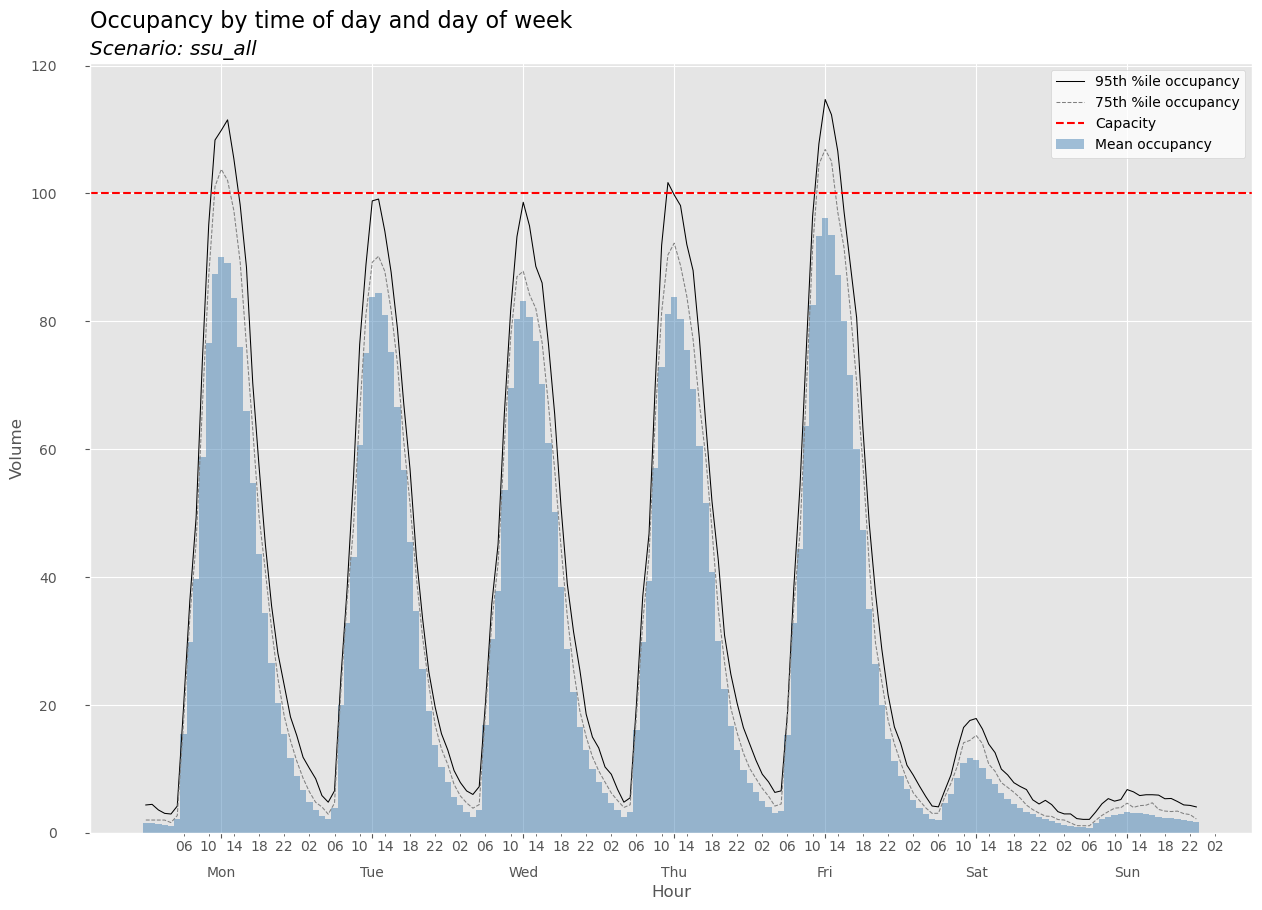

In [8]:
ssu_all.get_plot()

Let's assume we need to temporarily close 40 beds. Which patient populations can we move out of the SSU temporarily in order to deal with the reduced capacity?

In [9]:
patient_types = stops_df['PatType'].unique()
patient_types

array(['IVT', 'MYE', 'CAT', 'ART', 'OTH'], dtype=object)

In [10]:
import itertools

In [11]:
[_ for _ in itertools.combinations(patient_types, 2)]

[('IVT', 'MYE'),
 ('IVT', 'CAT'),
 ('IVT', 'ART'),
 ('IVT', 'OTH'),
 ('MYE', 'CAT'),
 ('MYE', 'ART'),
 ('MYE', 'OTH'),
 ('CAT', 'ART'),
 ('CAT', 'OTH'),
 ('ART', 'OTH')]

In [12]:
# Create dict of fixed inputs
ssu_inputs = {'data': stops_df,
              'in_field': 'InRoomTS',
              'out_field': 'OutRoomTS',
              'start_analysis_dt': '2024-01-02',
              'end_analysis_dt': '2024-09-30',
              'cat_field': 'PatType',
              'bin_size_minutes': 60,
              'cap': 60,
              'export_all_week_plots': True
              'plot_export_path': './output'
             }

In [13]:
exclusions = [[_ for _ in itertools.combinations(patient_types, i)] for i in range(1,4)]

In [14]:
exclusions

[[('IVT',), ('MYE',), ('CAT',), ('ART',), ('OTH',)],
 [('IVT', 'MYE'),
  ('IVT', 'CAT'),
  ('IVT', 'ART'),
  ('IVT', 'OTH'),
  ('MYE', 'CAT'),
  ('MYE', 'ART'),
  ('MYE', 'OTH'),
  ('CAT', 'ART'),
  ('CAT', 'OTH'),
  ('ART', 'OTH')],
 [('IVT', 'MYE', 'CAT'),
  ('IVT', 'MYE', 'ART'),
  ('IVT', 'MYE', 'OTH'),
  ('IVT', 'CAT', 'ART'),
  ('IVT', 'CAT', 'OTH'),
  ('IVT', 'ART', 'OTH'),
  ('MYE', 'CAT', 'ART'),
  ('MYE', 'CAT', 'OTH'),
  ('MYE', 'ART', 'OTH'),
  ('CAT', 'ART', 'OTH')]]

In [15]:
exclusions[0]

[('IVT',), ('MYE',), ('CAT',), ('ART',), ('OTH',)]

In [16]:
for i in exclusions[1]:
    print(list(i))
    print('_'.join(list(i)))

['IVT', 'MYE']
IVT_MYE
['IVT', 'CAT']
IVT_CAT
['IVT', 'ART']
IVT_ART
['IVT', 'OTH']
IVT_OTH
['MYE', 'CAT']
MYE_CAT
['MYE', 'ART']
MYE_ART
['MYE', 'OTH']
MYE_OTH
['CAT', 'ART']
CAT_ART
['CAT', 'OTH']
CAT_OTH
['ART', 'OTH']
ART_OTH


In [19]:
help(hm.Scenario.get_plot)

Help on function get_plot in module hillmaker.scenario:

get_plot(self, flow_metric: str = 'occupancy', day_of_week: str = 'week')
    Get plot object for specified flow metric and whether full week or specified day of week.
    
    Parameters
    ----------
    flow_metric : str
        Either of 'arrivals', 'departures', 'occupancy' ('a', 'd', and 'o' are sufficient).
        Default='occupancy'
    day_of_week : str
        Either of 'week', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'. Default='week'
    
    Returns
    -------
    plot object from matplotlib



In [47]:
exclusions = [[_ for _ in itertools.combinations(patient_types, i)] for i in range(1,4)]

# Create container dictionary to store the weekly plots
plots = {}

# Main loop over number of patient types to exclude
for num_cats_excluded in range(1, 4):
    # Loop over each combination of patient types excluded (the -1 is for the zero index)
    for exclusion in exclusions[num_cats_excluded - 1]:
        cats_to_exclude = exclusion
        print(f'cats_to_exclude = {cats_to_exclude}')
        scenario_name = f'no_{"_".join(list(exclusion))}'
        print(scenario_name)
        
        # Create scenario object
        scenario = hm.create_scenario(params_dict=ssu_inputs, 
                                      scenario_name=scenario_name, cats_to_exclude=cats_to_exclude)
        # Make the hills
        scenario.make_hills()
        
        # Create the weekly plot (they're also being exported)
        plots[scenario_name] = scenario.get_plot()
    

cats_to_exclude = ('IVT',)
no_IVT
cats_to_exclude = ('MYE',)
no_MYE
cats_to_exclude = ('CAT',)
no_CAT
cats_to_exclude = ('ART',)
no_ART
cats_to_exclude = ('OTH',)
no_OTH
cats_to_exclude = ('IVT', 'MYE')
no_IVT_MYE
cats_to_exclude = ('IVT', 'CAT')
no_IVT_CAT
cats_to_exclude = ('IVT', 'ART')
no_IVT_ART
cats_to_exclude = ('IVT', 'OTH')
no_IVT_OTH
cats_to_exclude = ('MYE', 'CAT')
no_MYE_CAT
cats_to_exclude = ('MYE', 'ART')
no_MYE_ART
cats_to_exclude = ('MYE', 'OTH')
no_MYE_OTH
cats_to_exclude = ('CAT', 'ART')
no_CAT_ART
cats_to_exclude = ('CAT', 'OTH')
no_CAT_OTH
cats_to_exclude = ('ART', 'OTH')
no_ART_OTH
cats_to_exclude = ('IVT', 'MYE', 'CAT')
no_IVT_MYE_CAT
cats_to_exclude = ('IVT', 'MYE', 'ART')
no_IVT_MYE_ART
cats_to_exclude = ('IVT', 'MYE', 'OTH')
no_IVT_MYE_OTH
cats_to_exclude = ('IVT', 'CAT', 'ART')
no_IVT_CAT_ART
cats_to_exclude = ('IVT', 'CAT', 'OTH')
no_IVT_CAT_OTH
cats_to_exclude = ('IVT', 'ART', 'OTH')
no_IVT_ART_OTH
cats_to_exclude = ('MYE', 'CAT', 'ART')
no_MYE_CAT_ART
cats_

In [43]:
plots.keys()

dict_keys(['no_IVT', 'no_MYE', 'no_CAT', 'no_ART', 'no_OTH'])

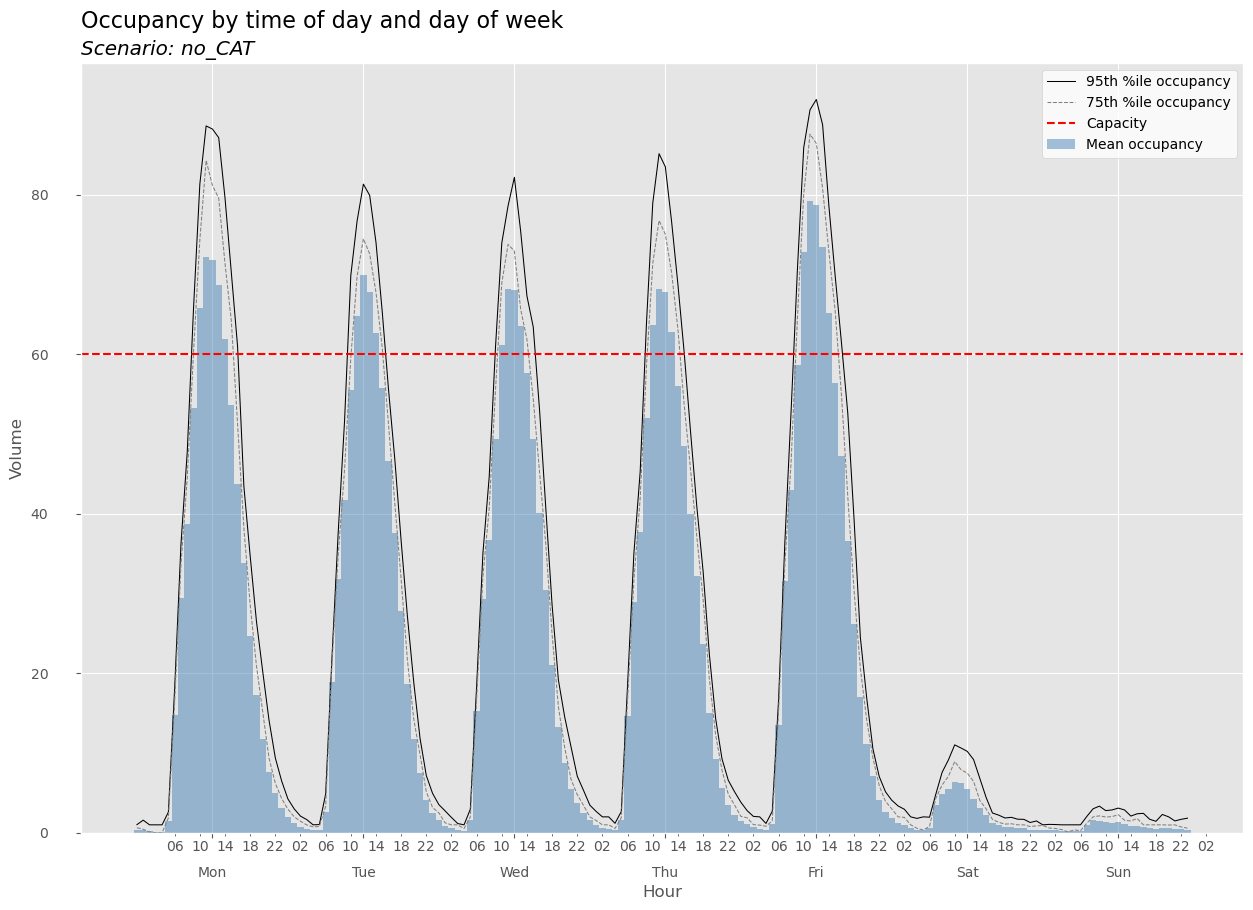

In [44]:
plots['no_CAT']